In [1]:
library(readr)
library(readxl)
library(dplyr)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(repr.plot.width = 20, repr.plot.height = 10)

In [196]:
library(fgsea)
get_gsea <- function(df) {
  df <- df %>% drop_na()
  # Ensure gene names are rownames and vector is a matrix
  gene_vec <- df$fold_change
  names(gene_vec) <- df$gene

  # Wrap into a matrix for GSVA (genes x samples)
  # Read GMT
  gmt <- gmtPathways("mapk.gmt")

  # Run ssGSEA
  ss <- fgsea(stats = gene_vec, pathways = gmt)

  # Return as data frame
  ss_df <- as.data.frame((ss))
  return(ss_df)
}


In [197]:
fold1_pred <- read_csv('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_58562784/holdout/eval_last.ckpt/C32_real_de.csv') %>% filter(grepl('Vemurafenib', target)) %>% mutate(cell_line = 'C32')
fold2_pred <- read_csv('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232/holdout/eval_last.ckpt/C32_real_de.csv') %>% filter(grepl('Vemurafenib', target))%>% mutate(cell_line = 'C32')

Rows: 1470000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1470000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [198]:
predicted1 <- read_csv("C32_pred_de.csv")
predicted2 <- read_csv("SK-MEL-2_pred_de.csv")
predicted1$cell_line <- 'C32'
predicted2$cell_line <- 'SK-MEL-2'
predicted <- bind_rows(predicted1, predicted2)
ground_truth1 <- read_csv("C32_real_de.csv")
ground_truth2 <- read_csv("SK-MEL-2_real_de.csv")
ground_truth1$cell_line <- 'C32'
ground_truth2$cell_line <- 'SK-MEL-2'
ground_truth <- bind_rows(ground_truth1, ground_truth2)

Rows: 6000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec

In [199]:
library(reticulate)
library(dplyr)

# Load numpy and the .npy file
np <- import("numpy")
gene_names <- np$load("/large_storage/ctc/userspace/aadduri/datasets/tahoe_19k_to_2k_names.npy", allow_pickle = TRUE)
# Convert to R character vector
gene_names <- as.character(gene_names)
# Create a data frame mapping index to gene name
gene_map <- tibble(
  feature = seq_along(gene_names) - 1,  # Python 0-based index
  gene = gene_names
)
# Join with your predicted data frame
predicted <- predicted %>%
  left_join(gene_map, by = "feature")
ground_truth<- ground_truth %>%
  left_join(gene_map, by = "feature")
fold1_pred<- fold1_pred %>%
  left_join(gene_map, by = "feature")
fold2_pred<- fold2_pred %>%
  left_join(gene_map, by = "feature")

In [200]:

fold2_pred_gsea <- fold2_pred %>%
  group_by(cell_line, target) %>% 
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (24.95% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 9 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (32.94% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 9 pathways for which P-values were not calculated properly du

In [204]:

fold1_pred_gsea <- fold1_pred %>%
  group_by(cell_line, target) %>% 
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.39% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 3 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (32.31% of the list).
The order of 

In [205]:
grounds_gsea <- ground_truth %>%
  group_by(cell_line, target) %>%
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

predicted_gsea <- predicted %>%
  group_by(cell_line, target) %>%
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (13.09% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-50. You can set the `eps` argument to zero for better estimation.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (17.1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (11.78% of the list

In [206]:
unique(merged2$cell_line)

[1] "C32"      "SK-MEL-2"

In [210]:
# Step 1: merge predicted and truth
merged <- merge(predicted_gsea, grounds_gsea, by = c('cell_line', 'target', 'pathway'), suffixes = c("_predicted", "_truth"))

# Step 2: merge with fold1
merged2 <- merge(merged1, fold1_pred_gsea, by = c('cell_line', 'target', 'pathway'), all = TRUE)
names(merged2)[names(merged2) == "NES"] <- "NES_fold1"

# Step 3: merge with fold2
merged <- merge(merged2, fold2_pred_gsea, by = c('cell_line', 'target', 'pathway'), all = TRUE)
names(merged)[names(merged) == "NES"] <- "NES_fold2"


In [211]:
merged$cell_line <- ifelse(
  merged$cell_line == 'C32',
  'C32 - BRAF v600E mutant Melanoma',
  'SK-MEL-2 - W.T. BRAF melanoma'
)

In [212]:
merged <- merged %>% pivot_longer(c('NES_predicted', 'NES_truth', 'NES_fold1', 'NES_fold2')) %>% as.data.frame()


In [213]:
merged$name <- ifelse(merged$name == 'NES_truth', 'True Normalized Enrichment', 'predicted Normalized Enrichment')

In [214]:
set <- c('GOBP_REGULATION_OF_CYCLASE_ACTIVITY' )

In [215]:
library(ggpubr)

In [216]:
library(dplyr)
library(stringr)

merged <- merged %>%
  mutate(dose = str_split_fixed(target, ",", 2)[, 2]) %>%
  mutate(dose = as.numeric(dose))


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `dose = as.numeric(dose)`.
Caused by warning:
! NAs introduced by coercion”


Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_compare_means()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


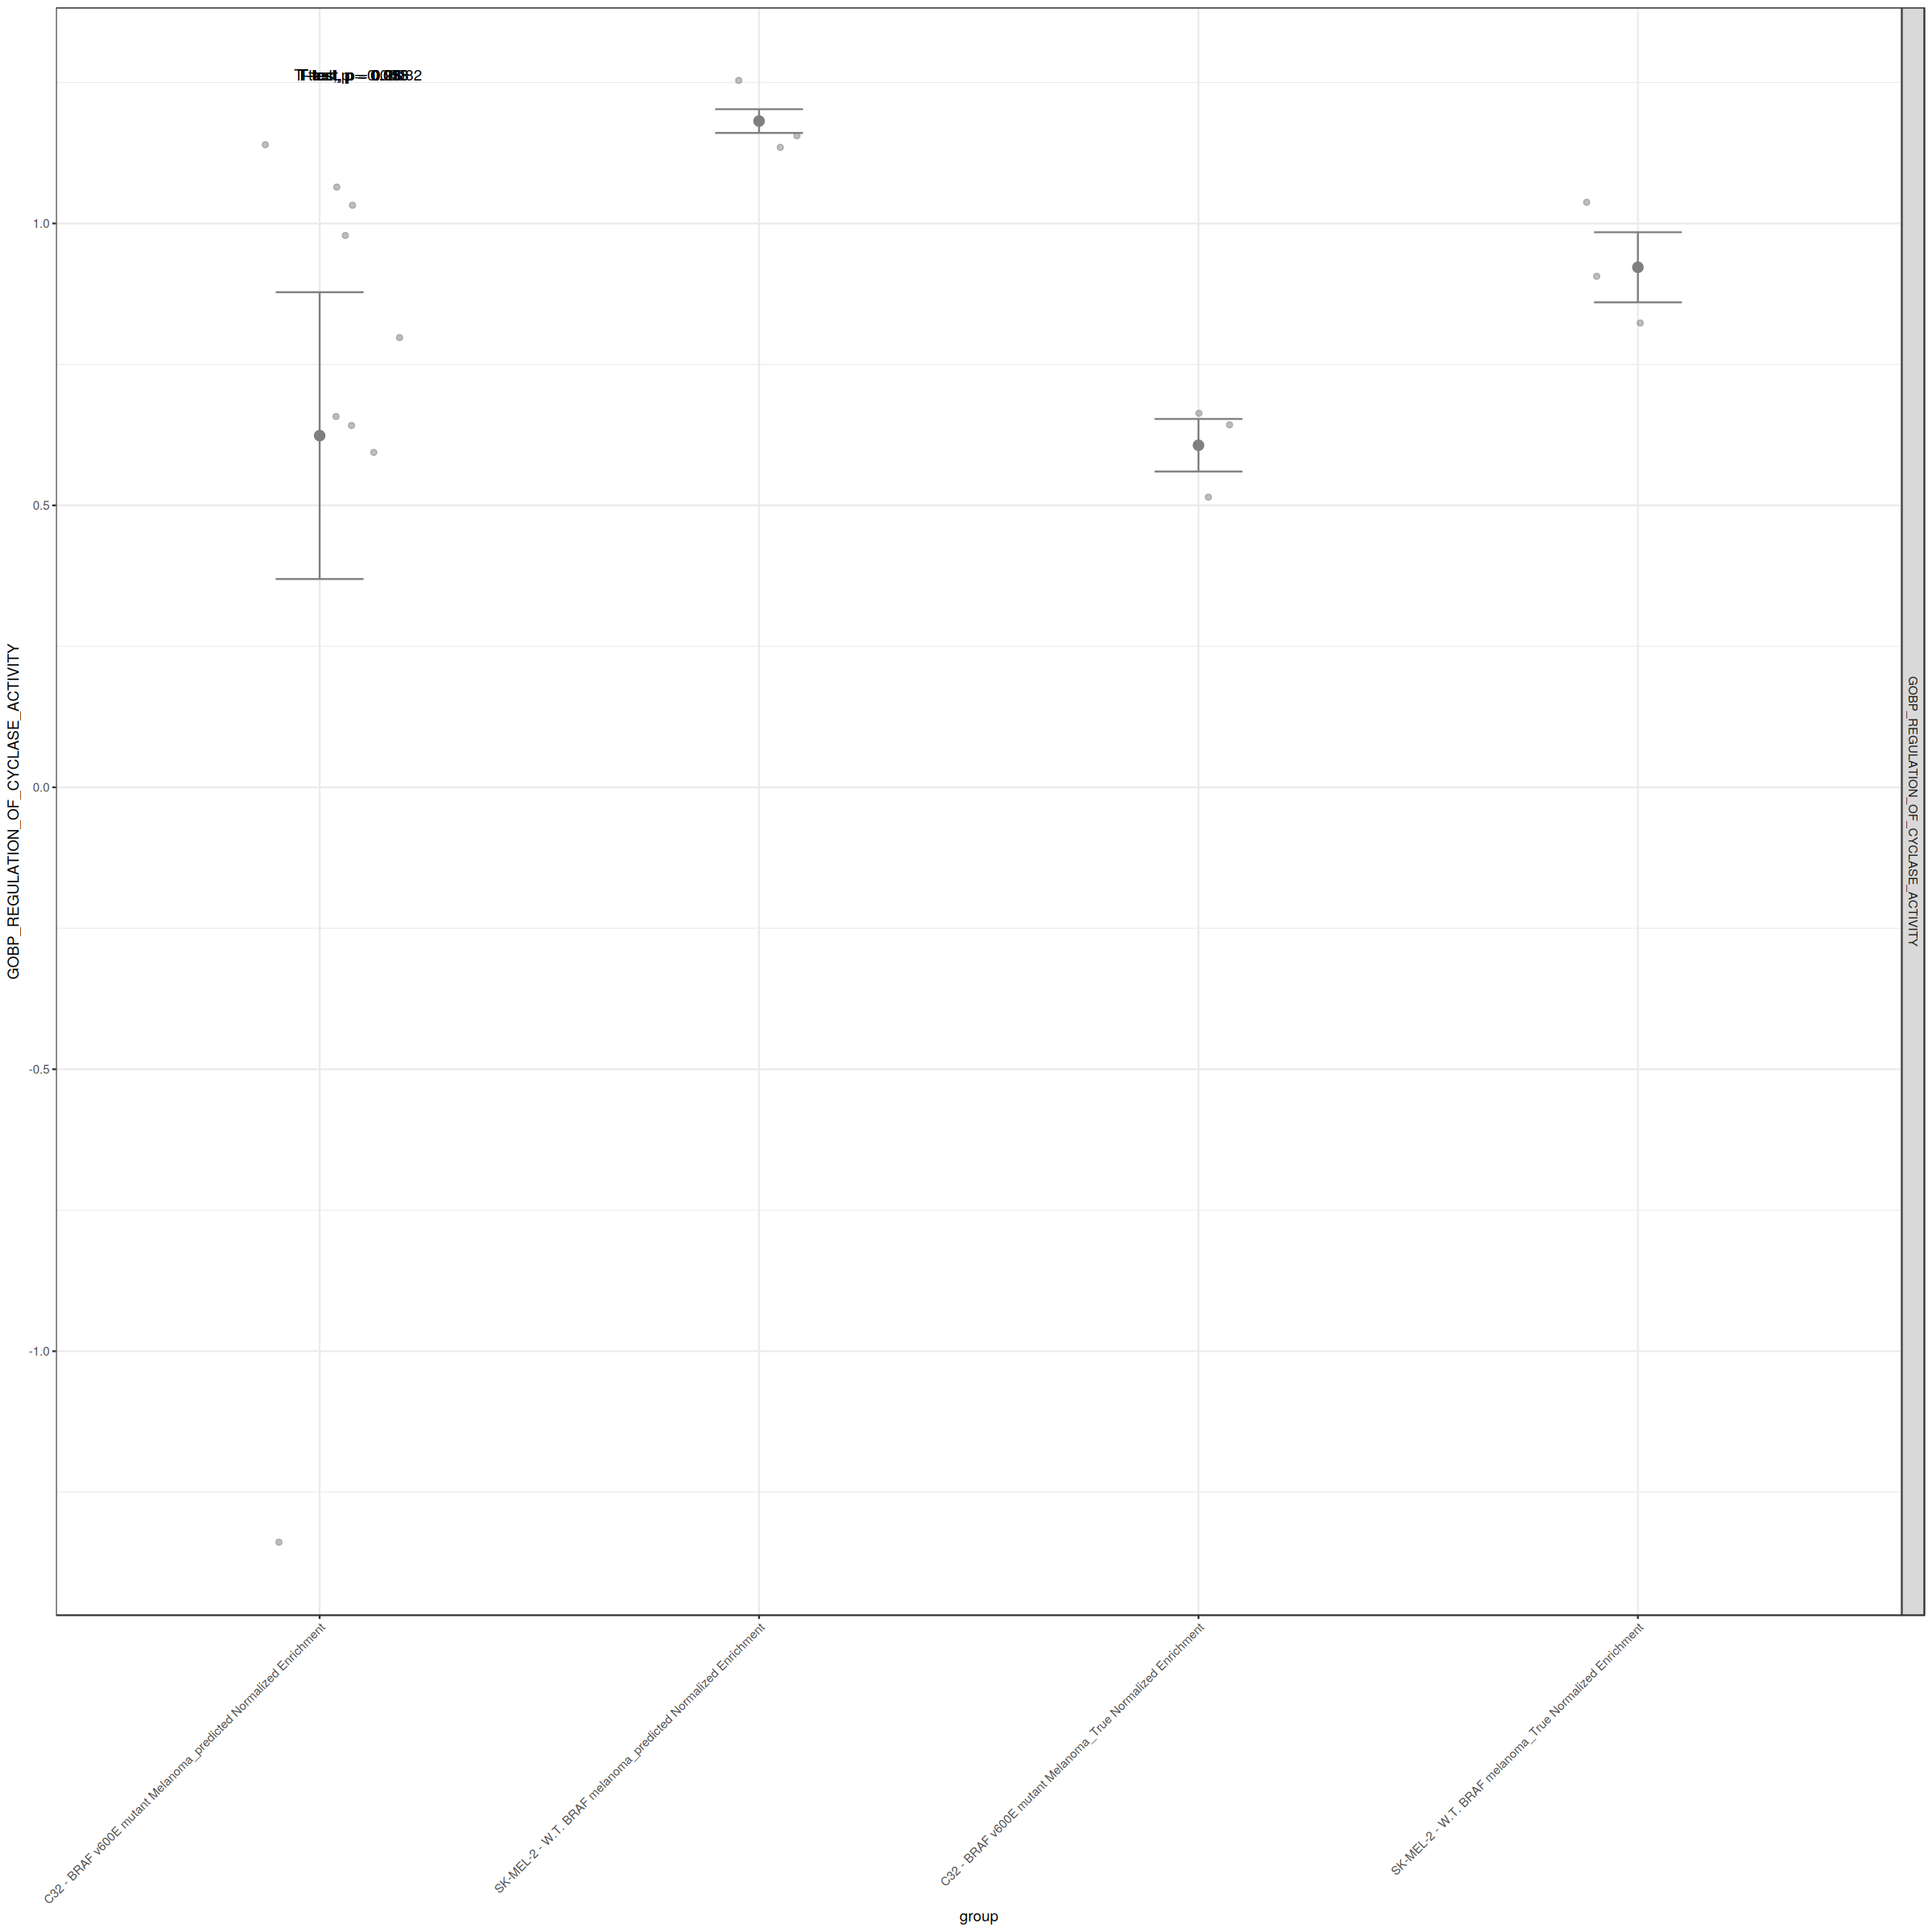

In [217]:
# Assuming 'name' contains your true/predicted labels
merged <- merged %>%
  mutate(group = interaction(cell_line, name, sep = "_"))

summary_df <- summary_df %>%
  mutate(group = interaction(cell_line, name, sep = "_"))

p <- ggplot(
  merged %>% filter(pathway %in% set),
  aes(x = group, y = value, color = dose)
) +
  geom_point(position = position_jitter(width = 0.2), alpha = 0.5) +
  geom_errorbar(
    data = summary_df,
    aes(
      x = group,
      y = mean_value,
      ymin = mean_value - se,
      ymax = mean_value + se,
      color = dose
    ),
    inherit.aes = FALSE,
    width = 0.2
  ) +
  geom_point(
    data = summary_df,
    aes(x = group, y = mean_value, color = dose),
    inherit.aes = FALSE,
    size = 3
  ) +
  stat_compare_means(method = "t.test") +
  theme_bw() +
  facet_grid(rows = vars(pathway)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylab("GOBP_REGULATION_OF_CYCLASE_ACTIVITY")

print(p)

In [224]:
options(repr.plot.width = 10, repr.plot.height = 10)

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_point()`).”


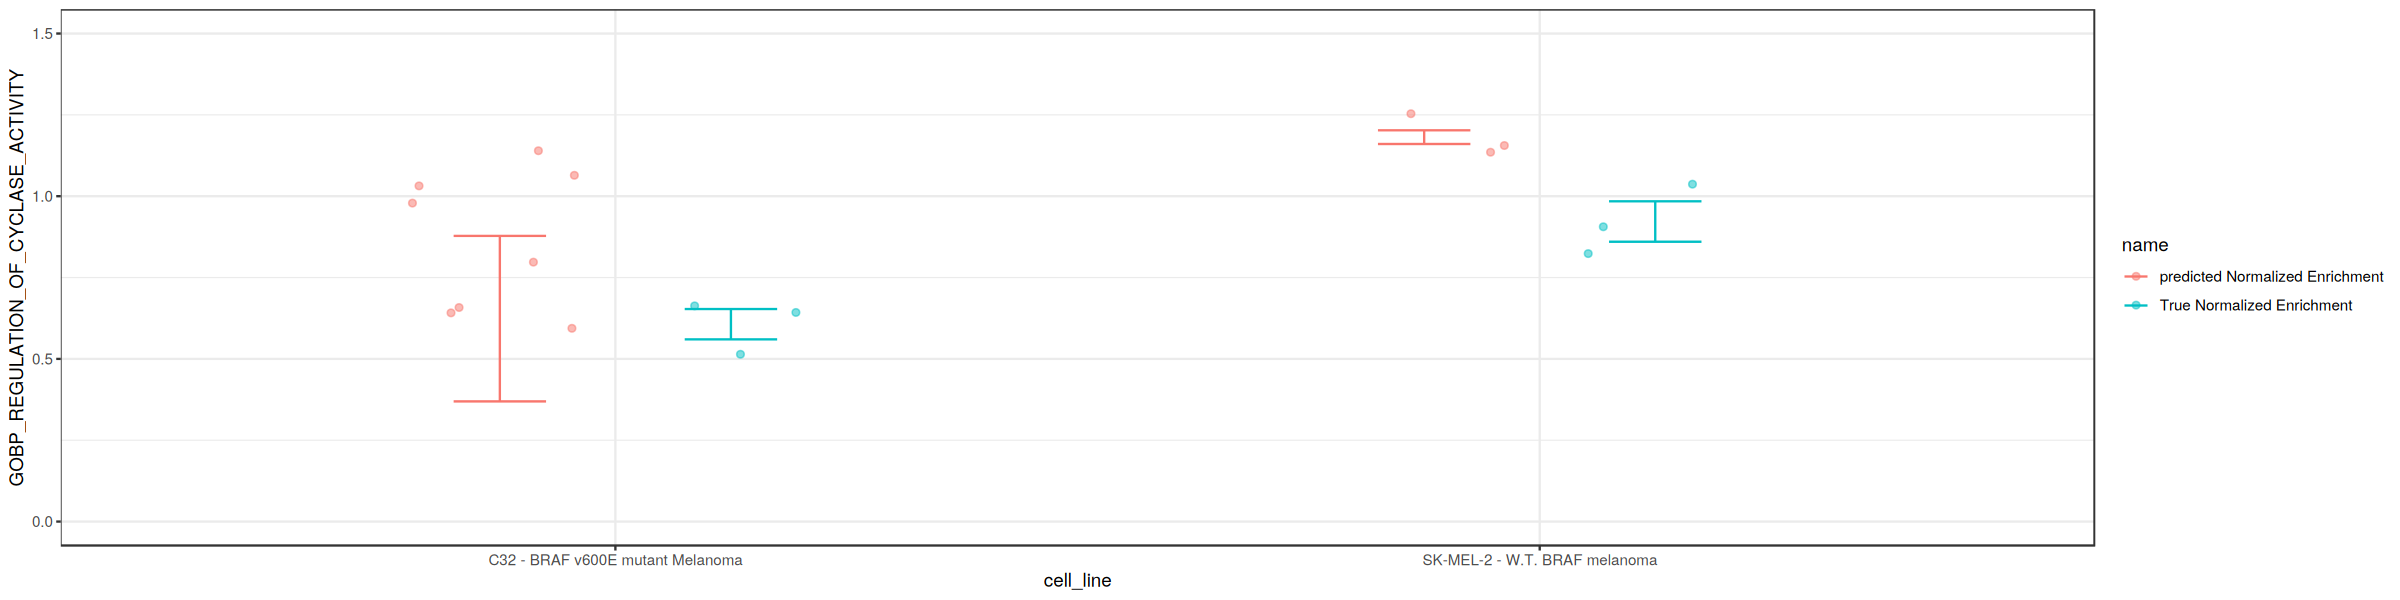

In [241]:
library(ggplot2)
library(ggpubr)

# Define comparisons for both scenarios
cell_line_comparisons <- list(c('C32 - BRAF v600E mutant Melanoma',
                               'SK-MEL-2 - W.T. BRAF melanoma'))

dodge_width <- 0.5

p <- ggplot(
  merged %>% filter(pathway %in% set),
  aes(x = cell_line, y = value, color = name, fill = name)
) +
  geom_point(
    position = position_jitterdodge(jitter.width = 0.2, dodge.width = dodge_width),
    alpha = 0.5
  ) +
  geom_errorbar(
    data = summary_df,
    aes(
      x = cell_line,
      y = mean_value,
      ymin = mean_value - se,
      ymax = mean_value + se,
      color = name
    ),
    inherit.aes = FALSE,
    position = position_dodge(width = dodge_width),
    width = 0.2
  ) + 
  ylim(0, 1.5) + 
  # T-test comparing cell lines within each 'name' group
  # T-test comparing 'name' groups within each cell line
  theme_bw() +
  ylab("GOBP_REGULATION_OF_CYCLASE_ACTIVITY")

print(p)

In [ ]:
ggsave('BRAF_predictions.pdf', p)

In [237]:
options(repr.plot.width = 20, repr.plot.height = 5)

Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_compare_means()`).”


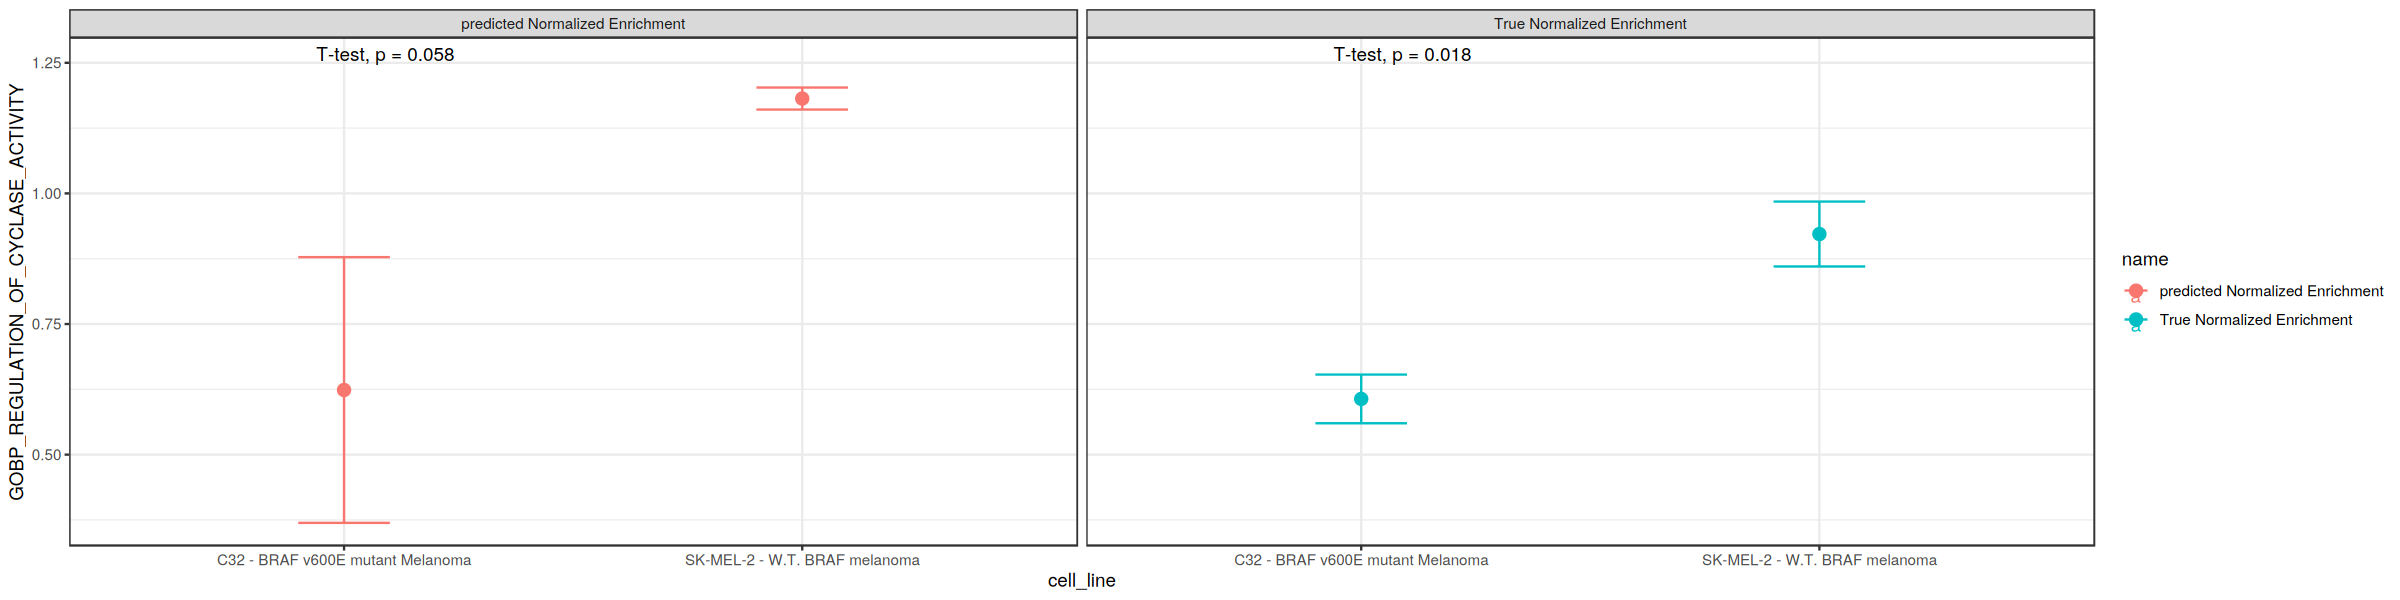

In [238]:
p <- ggplot(
  merged %>% filter(pathway %in% set),
  aes(x = cell_line, y = value, color = name, fill = name)
) +
  geom_errorbar(
    data = summary_df,
    aes(
      x = cell_line,
      y = mean_value,
      ymin = mean_value - se,
      ymax = mean_value + se,
      color = name
    ),
    inherit.aes = FALSE,
    position = position_dodge(width = dodge_width),
    width = 0.2
  ) +
  geom_point(
    data = summary_df,
    aes(x = cell_line, y = mean_value, color = name, fill = name),
    inherit.aes = FALSE,
    position = position_dodge(width = dodge_width),
    size = 3,
    shape = 21
  ) +
  stat_compare_means(aes(group = cell_line), method = "t.test") +
  facet_wrap(~ name, scales = "free_x") +  # ← test within each name
  theme_bw() +
  ylab("GOBP_REGULATION_OF_CYCLASE_ACTIVITY")

print(p)


In [239]:
ggsave('BRAF_enrichment_facets.pdf',p)

Saving 7 x 7 in image
Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_compare_means()`).”
